# Parsing table data from PDF with pdfplumber

Download the original source of data: [A report on the population projection for India](https://www.iipsindia.ac.in/sites/default/files/FULL_REPORT_WITH_FINAL_TABLES.pdf):

In [1]:
link = r'https://www.iipsindia.ac.in/sites/default/files/FULL_REPORT_WITH_FINAL_TABLES.pdf'
source = r'FULL_REPORT_WITH_FINAL_TABLES.pdf'

In [2]:
! [ -f '{source}' ] && echo 'The data has been downloaded' || wget '{link}'

The data has been downloaded


In [3]:
import pdfplumber
print(f'{pdfplumber.__version__ = }')   # 0.11.4

pdfplumber.__version__ = '0.11.4'


## Problem statement

The number of supposedly uniform tables in the data source is too large for errors not to occur. Therefore, we need a data extraction method that is resilient to inevitable inconsistencies in the formatting and filling of tables. 

## Using extract_tables to grab the data

When [extracting tables](https://github.com/jsvine/pdfplumber?tab=readme-ov-file#extracting-tables) with `extract_tables`, we have [4 strategies](https://github.com/jsvine/pdfplumber?tab=readme-ov-file#table-extraction-strategies) available:

* `"lines"` - use the page's graphical lines (default option)
* `"lines_strict"` - the same but without the sides of rectangle objects
* `"text"` -  deduce the lines that connect the left, right, or center of  words
* `"explicit"` - use the explicitly defined lines 

Unfortunately, we can't rely on the default `"lines"` table extraction method because tables may lack some borders or have other formatting issues, which may result in gluing or loss of some data:

![example_with_missing_borders](./image/example_with_missing_borders.jpg)

Note how the data was skipped in the following example due to the missing border on the right:

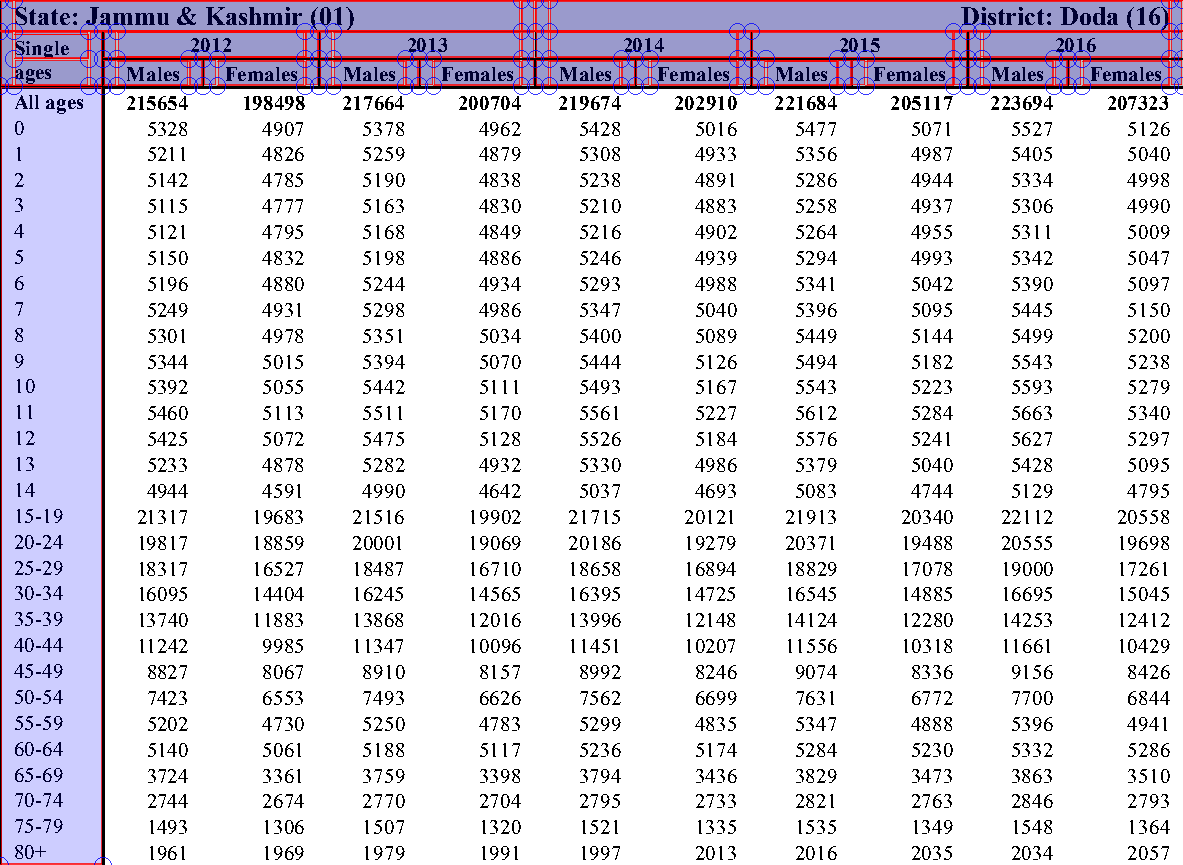

In [4]:
with pdfplumber.open(source) as pdf:
    page = pdf.pages[78]
    bbox = page.find_tables()[0].bbox
    display(page.crop(bbox)
            .to_image(resolution=200)
            .debug_tablefinder())

Also, we have to take into account that the main data body is not divided into cells in any way, so neither `"line"` nor `"lines_strict"` will help us accurately separate the numbers.

As for `"explicit"`, it seems impossible to find positions for either column or row lines that would fit all tables on all pages, for example:

![examples of distorted table positions on a page](./image/example_of_not_aligned_tables.jpg)

So the only strategy to use in this case is `"text"`. To minimize noise, we have to focus on the main body, i.e. we should crop the page to the part from the first to the last data line (supposedly from `"All ages"` to `"80+"`):

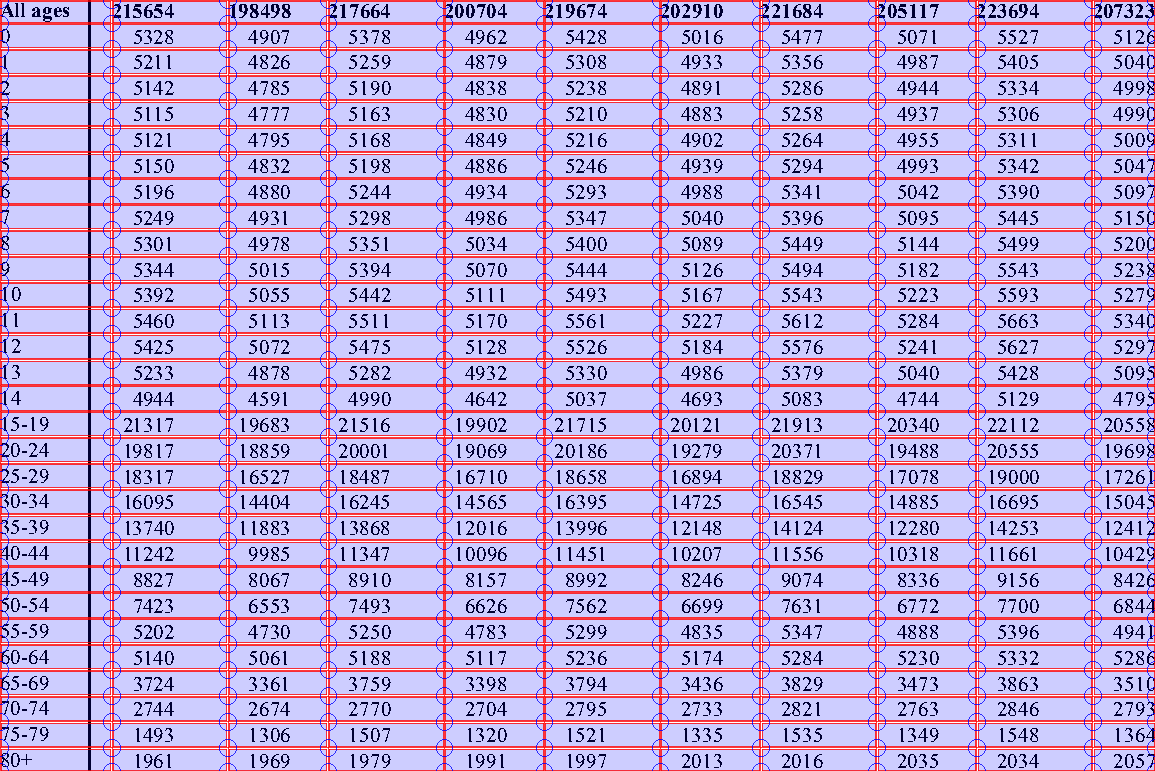

In [5]:
with pdfplumber.open(source) as pdf:
    page = pdf.pages[78]    

    # find the top-left and bottom-right corners of the first table
    records = iter(page.extract_text_lines())
    bbox = []
    for r in records:
        if r['text'].startswith('All ages'):    # first data line
            bbox.extend([r['x0'], r['top']])
            break
    for r in records:        
        if r['text'].startswith('80+'):         # last data line
            bbox.extend([r['x1'], r['bottom']])
            break

    # use aligned words to extract the table
    table_settings = {
        "vertical_strategy": "text", 
        "horizontal_strategy": "text",
    }

    # check how the data will be extracted
    display(page.crop(bbox).to_image(resolution=200).debug_tablefinder(table_settings))

In [6]:
import csv
from io import StringIO

with StringIO() as file:
    
    # extract and save the data as CSV
    table = page.crop(bbox).extract_table(table_settings)
    csv.writer(file).writerows(table)
    
    # read saved data
    file.seek(0)
    print(file.read())

All ages,215654,198498,217664,200704,219674,202910,221684,205117,223694,207323
0,5328,4907,5378,4962,5428,5016,5477,5071,5527,5126
1,5211,4826,5259,4879,5308,4933,5356,4987,5405,5040
2,5142,4785,5190,4838,5238,4891,5286,4944,5334,4998
3,5115,4777,5163,4830,5210,4883,5258,4937,5306,4990
4,5121,4795,5168,4849,5216,4902,5264,4955,5311,5009
5,5150,4832,5198,4886,5246,4939,5294,4993,5342,5047
6,5196,4880,5244,4934,5293,4988,5341,5042,5390,5097
7,5249,4931,5298,4986,5347,5040,5396,5095,5445,5150
8,5301,4978,5351,5034,5400,5089,5449,5144,5499,5200
9,5344,5015,5394,5070,5444,5126,5494,5182,5543,5238
10,5392,5055,5442,5111,5493,5167,5543,5223,5593,5279
11,5460,5113,5511,5170,5561,5227,5612,5284,5663,5340
12,5425,5072,5475,5128,5526,5184,5576,5241,5627,5297
13,5233,4878,5282,4932,5330,4986,5379,5040,5428,5095
14,4944,4591,4990,4642,5037,4693,5083,4744,5129,4795
15-19,21317,19683,21516,19902,21715,20121,21913,20340,22112,20558
20-24,19817,18859,20001,19069,20186,19279,20371,19488,20555,19698
25-2

But this approach has some pitfalls:
1. We can't always be sure that the top and bottom records start with the same phrases. 
1. A bottom-right cell may be empty, which can lead to incorrect corner detection. 
1. Data problems can also occur in the dataset itself and spoil the result.

![examples of problems](./image/example_issues_when_extrac_table.jpg)

## Extracting table data from text lines

Luckily, `pdfplumber` can accurately extract the lines. As far as the tables are well structured, we can use this to analyze the data before extracting or restoring tables.

At first, we grab the lines as is. But as far as the number of pages are too big, it seems reasonable to do it in chunks and clear the document cache in between to prevent memory overload (use the `flush_cache` method):

In [7]:
from itertools import pairwise      # to work with pairs of an iterable
from tqdm import tqdm               # to watch the loop progress
import shelve                       # to picle tha data for further reuse
from pprint import pprint           # to fine print the structured data
from collections import Counter     # to check the data amount

In [8]:
pdf = pdfplumber.open(source)
start, stop, step = 52, 1332, 100   # step is the chunk size
records = []
cicle, num_iterations = 0, (stop+step-start)//step
for first, last in pairwise(range(start, stop+step, step)):
    cicle += 1
    print(f'{cicle}/{num_iterations}')
    for p in tqdm(pdf.pages[first:last]):
        records.extend(p.extract_text().split('\n'))
    pdf.flush_cache()

1/13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.84it/s]


2/13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


3/13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]


4/13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.59it/s]


5/13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.76it/s]


6/13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.85it/s]


7/13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]


8/13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.39it/s]


9/13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.40it/s]


10/13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


11/13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


12/13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


13/13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [01:14<00:00,  1.08it/s]


In [9]:
# backup original records
database = 'collected_data.db'
with shelve.open(database) as db:
    db['records'] = records

We know that there should be:
1. 640 final tables, i.e. `(stop - start) / 2`
1. a unique table number and `State, District` pair for each final table
1. 2560 table parts, i.e. `(stop - start) * 2`
1. 30 rows and 10 number columns in each table part
1. anything else that could be disrupted by a typo, a change in column width or row height, an incorrect page order, etc.


Make sure that all pages are in place and in the correct order:

In [10]:
page_number = [int(r) for r in records if r.isnumeric()]

In [11]:
assert len(page_number) == stop - start
assert all(y-x == 1 for x, y in pairwise(page_number))

See if the number of tables and their parts are correct:

In [12]:
pprint({
    'number of tables': sum(x.startswith('Table') for x in records)
    , 'number of states': sum(x.startswith('State:') for x in records)
    , 'number of districts': sum('District:' in x for x in records)
    , 'number of state/district pairs': sum('State:' in x  and 'District:' in x for x in records)
})

{'number of districts': 2560,
 'number of state/district pairs': 2559,
 'number of states': 2560,
 'number of tables': 640}


Note that the number of records with state and district is 2559, which means there's one separated state and district pair:

In [13]:
for n, r in enumerate(records):
    if r.startswith('State:') and 'District:' not in r:
        print('\n'.join(records[n-1:n+2]))
        print('Record:', n)
        for r in records[n:]:
            if r.isnumeric():
                print('Page:', r)
                break
        break

District: Pashchimi Singhbhum
State: Jharkhand(05)
(23)
Record: 50543
Page: 776


Therefore, we have to manually connect records 50543, 50542, 50544 before extracting info about State and District:

In [14]:
# fix the separated state/district pair
records[n-1] = records[n] + ' ' + records[n-1] + records[n+1]
del records[n:n+2]

In [15]:
# collect state/district pairs
def extract_area(record):
    area = record.removeprefix('State:').split('District:', maxsplit=1)
    return tuple(x.split('(', maxsplit=1)[0].strip() for x in area)

area = Counter(extract_area(r) for r in records if r.startswith('State:'))
table_number = Counter(r.split(':', maxsplit=1)[0].removeprefix('Table.') for r in records if r.startswith('Table.'))
assert len(table_number) == 640
assert all(v == 1 for v in table_number.values())
print('Incorrect area count:', {k: v for k, v in area.items() if v!=4})

Incorrect area count: {('Manipur', 'Ukhrul'): 8, ('West Bengal', 'Paschim Medinipur'): 8}


With the code above we can see that it's possible to identify each table by their _table number_, but not with _State/District_ pairs. We have to decide somehow what to do with the following pairs:

In [16]:
exceptions = [('Manipur', 'Ukhrul'), ('West Bengal', 'Paschim Medinipur')]
for n, r in enumerate(records, start=1):
    if r.startswith('Table.'):
        while not records[n].startswith('State:'):
            n += 1
        for state, district in exceptions:
            if state in records[n] and district in records[n]:
                print(r)
                print(records[n])

Table.14.7: Projected Population by Age and Sex of Imphal East district of Manipur: 2012-2031.
State: Manipur (14) District: Ukhrul (08)
Table.14.8: Projected Population by Age and Sex of Ukhrul district of Manipur: 2012-2031.
State: Manipur (14) District: Ukhrul (08)
Table.19.18: Projected Population by Age and Sex of Paschim Medinipur district of West Bengal:
State: West Bengal (19) District: Paschim Medinipur (18)
Table.19.19: Projected Population by Age and Sex of Paschim Medinipur district of West Bengal:
State: West Bengal (19) District: Paschim Medinipur (18)


Looks like in Table 14.7 the district should be _Imphal East_. But _Paschim Medinipur_ is duplicated in table titles as well, so it looks like the name of some district was lost. Anyway, if we save the table number along with the state and district following after, we can identify data later and modify _state/district_ (see below in the following cells after constructing the final data frame).

Let's check the data consistency:

In [17]:
index = 'All ages', *map(str, range(15)), *(f'{x}-{x+4}' for x in range(15, 80, 5)), '80+'

number_of_index_occurrences = {key: sum(r.startswith(key + ' ') 
                                        for r in [x for x in records if not x.isnumeric()]) 
                               for key in index}
print('Number of missing records:', 
      {k: 2560-v for k, v in number_of_index_occurrences.items() if v != 2560})

Number of missing records: {'80+': 2}


So, we can't rely on `"80+"` as a marker for the last line by default. But we can use `"75-79"` for this purpose, checking if it's followed by "80+", or we have to insert calculated/fictive values for the two missing lines that should begin with "80+". And I think the latter is better for the simplicity of subsequent calculations. But before that, let's see if numbers are numbers:

In [18]:
numbers = {k: r.removeprefix(i).strip().split()
           for k, r in enumerate(records) for i in index
           if r.startswith(i + ' ')}

rows_not_10 = {k for k, r in numbers.items() if len(r) != 10}
rows_not_number = {k: r for k, r in numbers.items() if not all(n.isnumeric() for n in r)}
not_number = {x for r in rows_not_number.values() for x in r if not x.isnumeric()}

print(f'{not_number = }')

pages_not_10 = set()
for rec in rows_not_10:
    for r in records[rec+1:]:
        if r.isnumeric():
            pages_not_10.add(r)
            break
print(f'{pages_not_10 = }')

pages_not_numbers = set()
for rec in rows_not_number:
    for r in records[rec+1:]:
        if r.isnumeric():
            pages_not_numbers.add(r)
            break
print(f'{pages_not_numbers = }')

not_number = {'-229', '-7', '-226', '-219', '-124', '-125', 'Single', '-224', '-128', '-228', '-216', 'ag', '-218', '-129', '-126', '-231', '-34', '-223', '-127', '-8', '-221'}
pages_not_10 = {'850', '847'}
pages_not_numbers = {'850', '1323', '1324'}


![not numbers example](./image/example_not_numbers.jpg)

So, we have to manually replace `"Single ag"` and the empty cell with correct values, and decide if it’s okay to keep negative numbers as the population amount (let's suppose negative numbers are okay). 

In [19]:
# fix "Single ag" on page 850
for n, r in enumerate(records):
    if r.startswith('All ages') and 'Single ag' in r:
        break

assert records[n+30-1].startswith('80+')

position = len(records[n].removeprefix('All ages').split('Single ag')[0].split())
data = [[*map(int, r.split()[-10:])] for r in records[n+1:n+30]]
new_value = str(sum(row[position] for row in data))
records[n] = records[n].replace('Single ag', new_value)

In [20]:
# fix the empty field on page 847
for n, r in enumerate(records):
    if r.startswith('All ages') and len(r.split()) == 11:
        break
else:
    raise ValueError('Looks like there\'s no empty fields')

assert records[n+30-1].startswith('80+')

position = 8
data = [[*map(int, r.split()[-10:])] for r in records[n+1:n+30]]
new_value = str(sum(row[position] for row in data))
left, right = records[n].rsplit(maxsplit=1)
records[n] = ' '.join([left, new_value, right])

In [21]:
# restore missing "80+" records
import numpy as np

new_values = {}
for n, r in enumerate(records, start=1):
    if r.startswith('75-79') and not records[n].startswith('80+'):
        arr = np.array([[*map(int, r.split()[-10:])] for r in records[n-29:n]])   # 29 is the number of indexes without "80+"
        new_values[n] = f"80+ {' '.join(map(str, arr[0] - arr[1:].sum(0)))}"

In [22]:
# see if we can replace without inserting
for n in new_values:
    print(records[n])

(Contd…)
(Contd…)


In [23]:
# replace the meaningless "(Contd…)" records with missing "80+" instead of inserting
for n, v in new_values.items():
    records[n] = v

With the issues mentioned above fixed, we can start collecting data:

In [24]:
import pandas as pd
print('pandas', pd.__version__)

pandas 2.2.1


In [25]:
index = 'All ages', *map(str, range(15)), *(f'{x}-{x+4}' for x in range(15, 80, 5)), '80+'
index = pd.Index(index, name='Age')
columns = pd.MultiIndex.from_product([range(2012, 2032), ['Males', 'Females']])
data = []
height = len(index)
n = 0
while True:      # Alternative: for _ in range((last_page-first_page-1)/2)
    table = {}
    while n < len(records) and not records[n].startswith('Table.'):
        n += 1
    if n == len(records):
        break
    table_id = records[n].split(':', maxsplit=1)[0].removeprefix('Table.')
    n += 1
    while not records[n].startswith('State:'):
        n += 1
    state, district = extract_area(records[n]) 
    n += 1
    for i in range(4):
        while not records[n].startswith('All ages'):
            n += 1
        table[i] = [[*map(int, r.rsplit(maxsplit=10)[-10:])] for r in records[n:n+height]]
        n = n + height
    table = [[table[i][j][k] for i in range(4) for k in range(10)]
             for j in range(height)]   # for each age collect 10 cells from each of the 4 parts
    data.append(
        pd.DataFrame(table, index, columns)
        .assign(id=table_id, State=state, District=district) 
    )

In [26]:
# data index is saved when concatenating with default parameters
# at least in pandas version = 2.2.1
# if not, we include df.reset_index() when creating table data frames
# befor concatenating
result = pd.concat(data)

In [27]:
# fix issue with the district for 14.7-8 and 19.18-19
# see the page with original number 25 of the source document 
# for these substitutions (it's index is 32):
# display(pdf.pages[32].page.to_image(resolution=200))
result.loc[result['id'] == '14.7', 'District'] = 'Imphal East'
result.loc[result['id'] == '19.19', 'District'] =  'Purba Medinipur'

![district correction](./image/district_correction.jpg)

In [28]:
# set id, state, district as additional index levels
result = result.set_index(['id', 'State', 'District'], append=True)

In [29]:
# save the result to excel
result.reorder_levels(['id', 'State', 'District', 'Age']).to_excel('data.xlsx', engine='openpyxl')

In [30]:
# estimate errors in data
total = result.loc['All ages']
values = result.loc[index.drop('All ages')]
error = (values.groupby(level=['id','State','District']).sum() - total).abs()

print('Max absolute difference with "All ages":', error.max().max())
print(f'Max relative error concerning "All ages": {(error/total).max().max():.5%}')

Max absolute difference with "All ages": 7
Max relative error concerning "All ages": 0.08172%


In [31]:
# select data about children of age < 6
kids = result.loc[map(str, range(6))]   

In [32]:
# save data in shelve
with shelve.open(database) as db:
    db['data'] = result
    db['kids'] = kids